<img
src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg"
WIDTH=180 HEIGHT=180>

<CENTER>
</br>
<p><font size="5">  TAF MCE - Machine Learning  </font></p>
<p><font size="5">  Decision trees </font></p>
<p><font size="3"></br>Fall 2023</font></br></div>
</p>
</CENTER>

----------------------------

The goal of this project is to implement and visualize decision trees. Both aspects of classification and regression will be studied using simple examples. Cross-validation procedures will be used to tune the important parameters of the trees. Monte Carlo methods, using an ensemble of decision trees, are also discussed.

In [62]:
# Install graphviz library (needed to plot a tree)
!pip install graphviz 
#or: !pip install python-graphviz #or: !sudo apt-get install graphviz

In [63]:
# Import classic libraries (Matplotlib and PyLab)
%matplotlib inline
%pylab inline

# Import scikit-learn functions
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostRegressor, AdaBoostClassifier
from sklearn.metrics import log_loss

# Import pandas
import pandas as pd

# Avoid warnings
import warnings
warnings.filterwarnings("ignore")

# Figure size
pylab.rcParams['figure.figsize'] = (16, 9)

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## I - Regression trees


Text(0, 0.5, 'y')

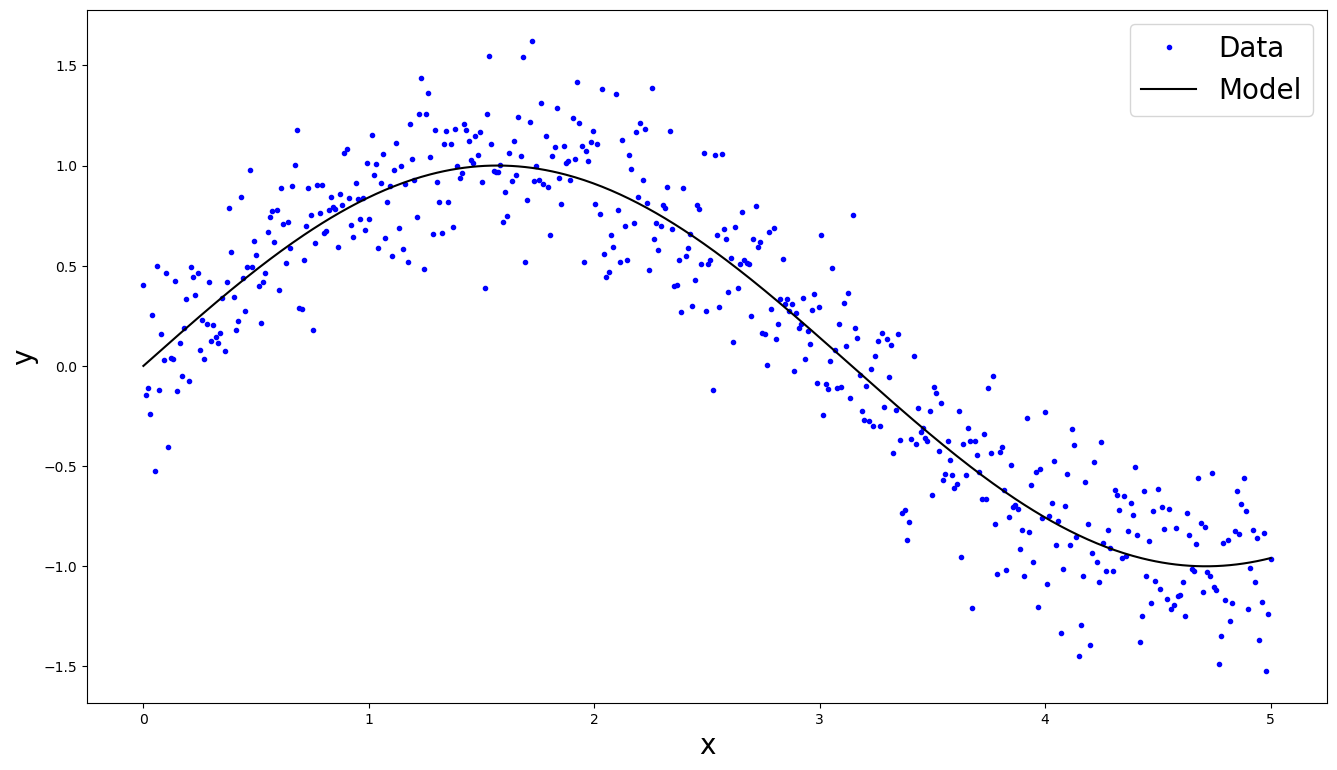

In [64]:
# 1. Generate x and y (adding an additive random noise of mean=0 and std=0.25 on y)

# Data generation
random.seed(1) # setting seed for reproducability
n = 500 # number of samples
x = array([linspace(0, 5, n)]).T
y = sin(x) + 0.25 * np.random.randn(n,1)

# Plot
line1, = plot(x, y, '.b')
line2, = plot(x, sin(x), '-k')
legend([line1, line2], ['Data', 'Model'], prop={'size': 20})
xlabel('x', size=20)
ylabel('y', size=20)

Text(0, 0.5, 'y')

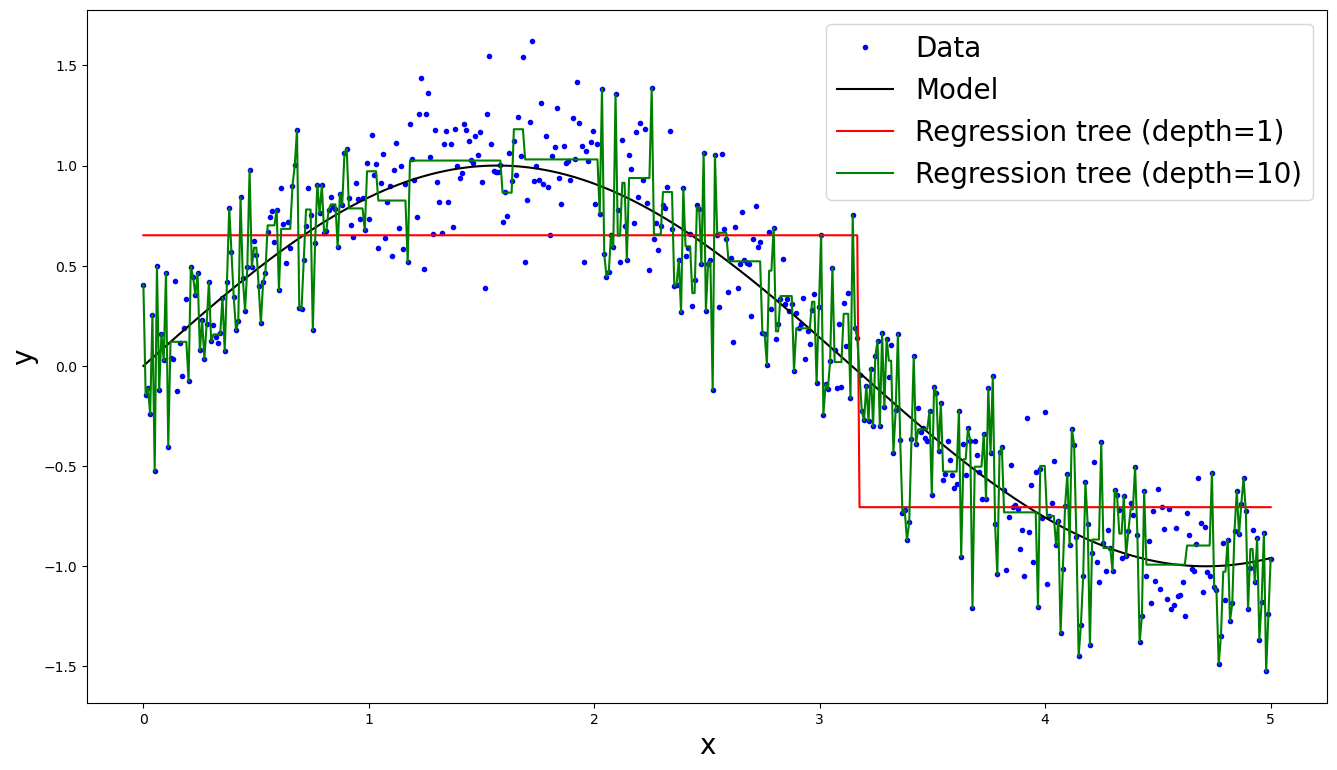

In [65]:
# 2. Apply a single regression tree with depth=1,...,10

# Build the tree (with depth=1)
reg_tree_example_1 = DecisionTreeRegressor(max_depth=1)
reg_tree_example_1.fit(x, y)
y_tree_example_1 = reg_tree_example_1.predict(x)

# Build the trees (with depth=10)
reg_tree_example_10 = DecisionTreeRegressor(max_depth=10)
reg_tree_example_10.fit(x, y)
y_tree_example_10 = reg_tree_example_10.predict(x)

# Plot
line1, = plot(x, y, '.b')
line2, = plot(x, sin(x), '-k')
line3, = plot(x, y_tree_example_1, '-r')
line4, = plot(x, y_tree_example_10, '-g')
legend([line1, line2, line3, line4], ['Data', 'Model', 'Regression tree (depth=1)', 'Regression tree (depth=10)'], prop={'size': 20})
xlabel('x', size=20)
ylabel('y', size=20)

We can see that a regression tree with depth 1 is underfitting, while a regressing tree with depth 10 is overfitting. The more the depth of a decision tree is high the more it is overfitting, and inversely the more it is small the more it is underfitting. Thus, we need to find the optimal depth in between 1 and 10 using cross validation.

Text(0, 0.5, 'RMSE')

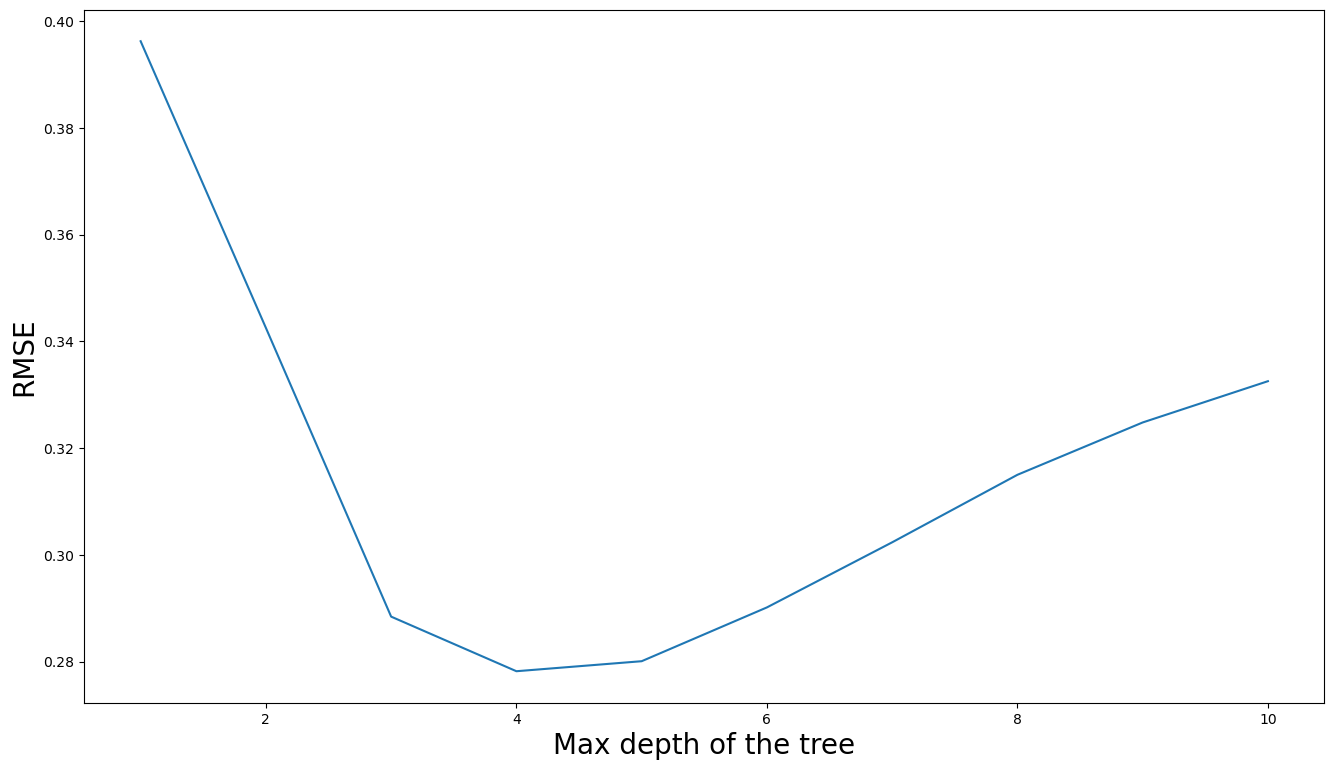

In [66]:
# 3. Optimize the depth of the tree using cross-validation

# Define the cvp (cross-validation procedure) with random 1000 samples, 2/3 training size, and 1/3 test size
cvp = ShuffleSplit(n_splits=1000, train_size=2/3, test_size=1/3, random_state=1)

# Define the max depths between 1 and 10
n_depths = 10
depths = linspace(1, 10, n_depths)

# Loop on the max_depth parameter and compute median RMSE
tab_RMSE_tree = zeros(n_depths)
for i in range(n_depths):
    reg_tree = DecisionTreeRegressor(max_depth=int(depths[i]))
    tab_RMSE_tree[i] = median(sqrt(-cross_val_score(reg_tree, x, y, scoring='neg_mean_squared_error', cv=cvp)))

# Plot
plot(depths, tab_RMSE_tree)
xlabel('Max depth of the tree', size=20)
ylabel('RMSE', size=20)

According to the graph above, the optimal depth (which minimize the RMSE using cross validation) is 4.

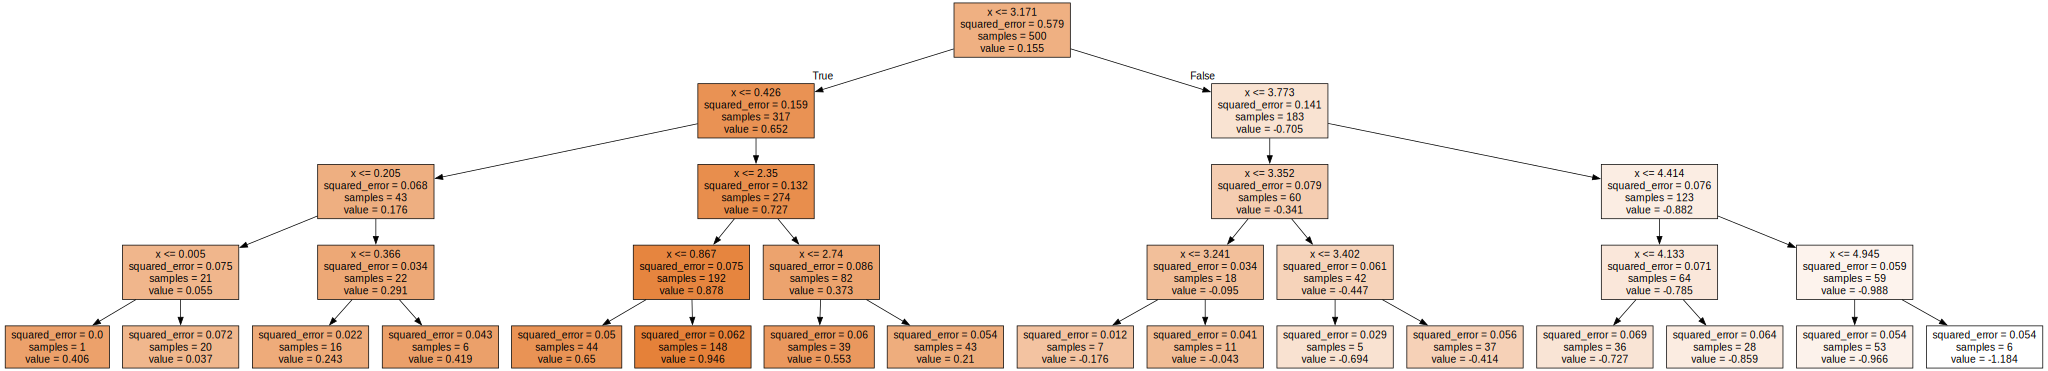

In [67]:
# 4. Compute and plot the tree with the optimal depth

# Adjust regression tree with optimal depth
reg_tree = DecisionTreeRegressor(max_depth=4)
reg_tree.fit(x, y)
y_tree = reg_tree.predict(x)

# Export the tree to "plot_tree.pdf"
plot_tree = export_graphviz(reg_tree, out_file=None, feature_names=['x'], filled=True) 
graph = Source(plot_tree) 
graph.render("reg_tree")

# Plot the tree
graph

Text(0, 0.5, 'y')

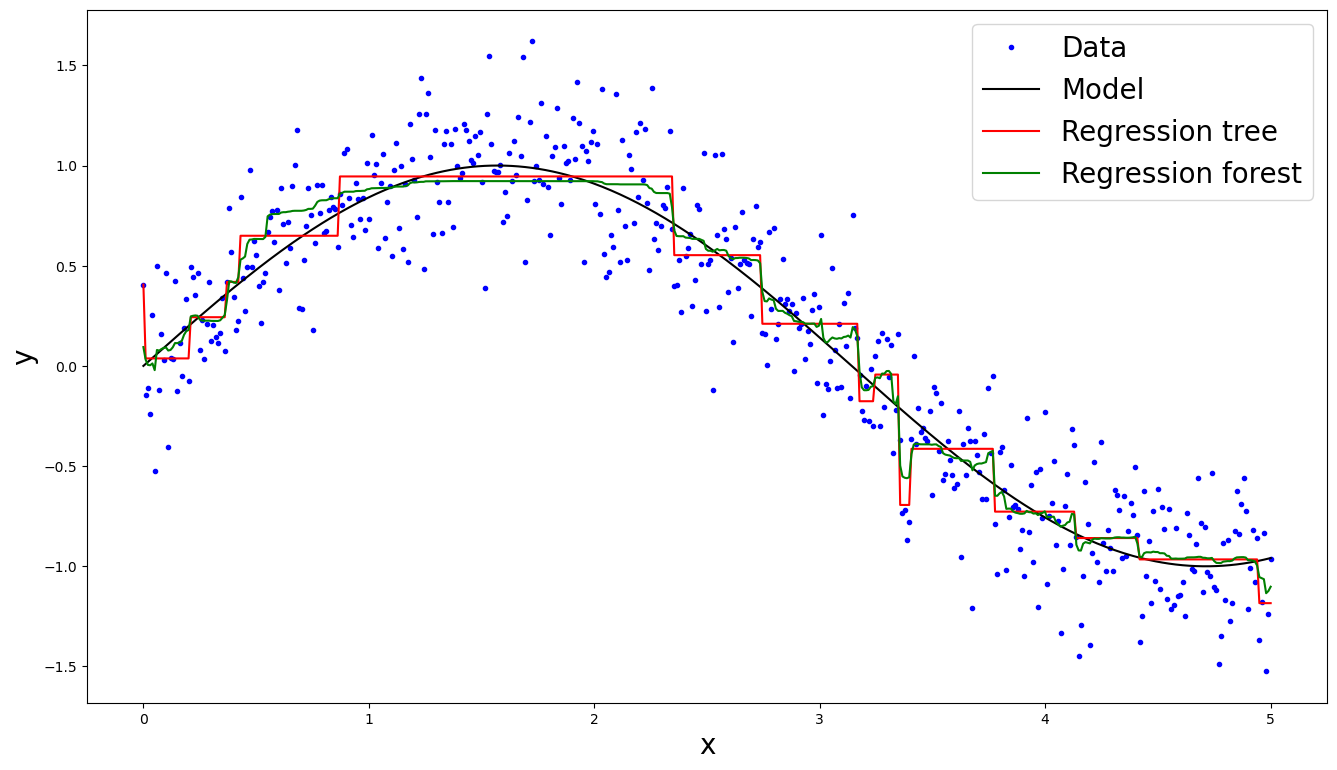

In [68]:
# 5. Implement a regression forest with the optimal depth

# Adjust regression forest using 1000 trees
reg_forest = RandomForestRegressor(n_estimators=1000, max_depth=4, random_state=1)
reg_forest.fit(x, y)
y_forest = reg_forest.predict(x)

# Plot
line1, = plot(x, y, '.b')
line2, = plot(x, sin(x), '-k')
line3, = plot(x, y_tree, '-r')
line4, = plot(x, y_forest, '-g')
legend([line1, line2, line3, line4], ['Data', 'Model', 'Regression tree', 'Regression forest'], prop={'size': 20})
xlabel('x', size=20)
ylabel('y', size=20)

The regression function obtained with the random forest is smoother than that produced by a decision tree, which is logical because a random forest combines predictions from multiple regression trees. This attribute of a random forest helps in avoiding overfitting and reducing variance.

## II - Single tree for binary classification

Here, we use a binary classification on the Titanic historical dataset. The goal is to understand the rules infered by the classification tree to predict the output variable (i.e., did people died or survived).


In [69]:
# 1. Import X and y

# Import dataset
data_titanic = pd.read_csv('titanic.csv')

# Read X and y
X = data_titanic.drop(['Survived'], axis=1).values
y = data_titanic['Survived'].values
y = (y>0.5) # transform to binary data

Here are some details about the dataset:
- Survived (False --> no, True --> yes)
- Pclass (1 --> 1st class, 2 --> 2nd class, 3 --> 3rd class)
- Sex (0 --> female, 1 --> male)
- Age (0 --> less than 16, 1 --> between 16 and 32, 2 --> between 32 and 48, 3 --> between 48 and 64, 4 --> more than 64)
- FamilySize (number of members in the family)
- Title (1 --> Mr, 2 --> Master, 3 --> Mrs, 4 --> Miss, 5 --> rare)

Text(0, 0.5, 'accuracy')

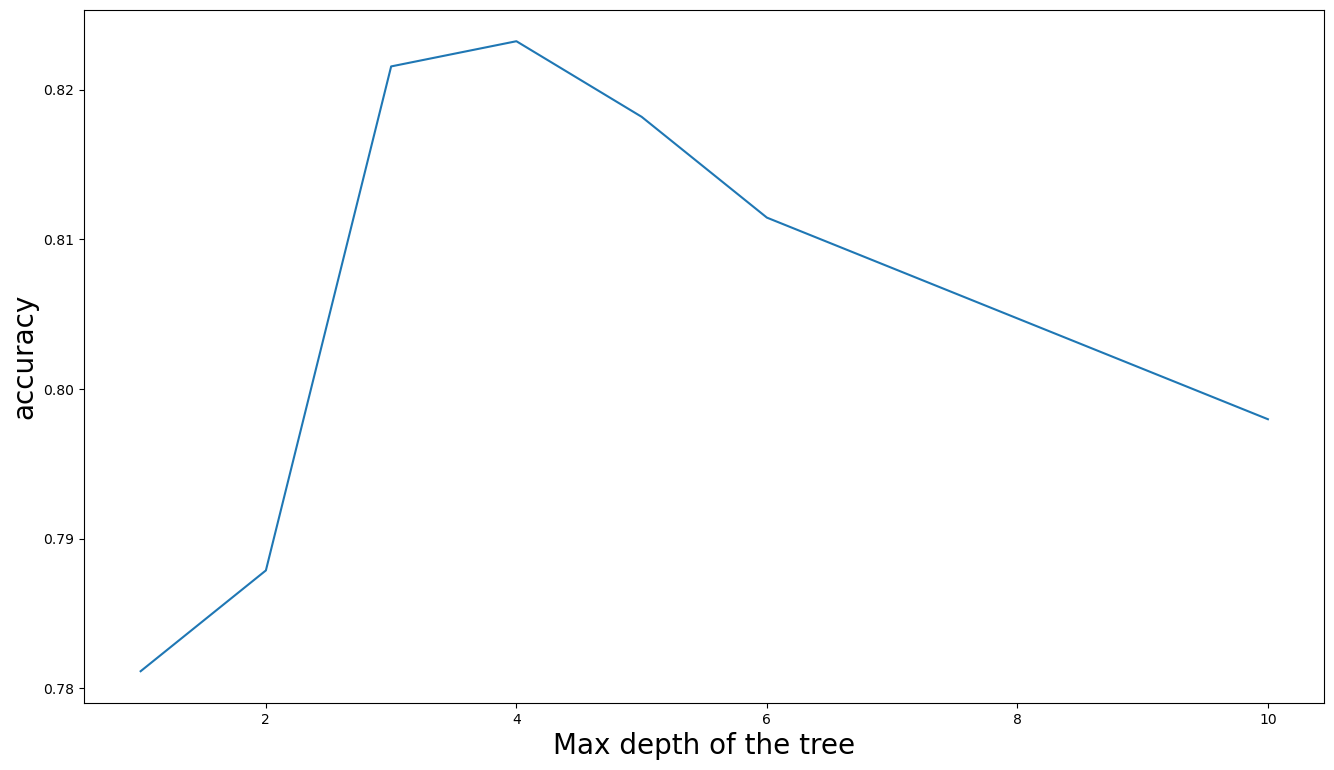

In [70]:
# 2. Use a cross-validation procedure to tune the depth of the classification tree

# Define the cvp (cross-validation procedure) with random 1000 samples, 2/3 training size, and 1/3 test size
cvp = ShuffleSplit(n_splits=1000, train_size=2/3, test_size=1/3, random_state=1)

# Define the max depths between 1 and 10
n_depths = 10
depths = linspace(1, 10, n_depths)

# Loop on the max_depth parameter and compute median RMSE
tab_entropy_tree = zeros(n_depths)
for i in range(n_depths):
    class_tree = DecisionTreeClassifier(max_depth=int(depths[i]))
    tab_entropy_tree[i] = median(cross_val_score(class_tree, X, y, scoring='accuracy', cv=cvp))

# Plot
plot(depths, tab_entropy_tree)
xlabel('Max depth of the tree', size=20)
ylabel('accuracy', size=20)

We can see that the optimal depth for the classification tree is 4: It is the depth that maximizes accuracy score for unseen data.

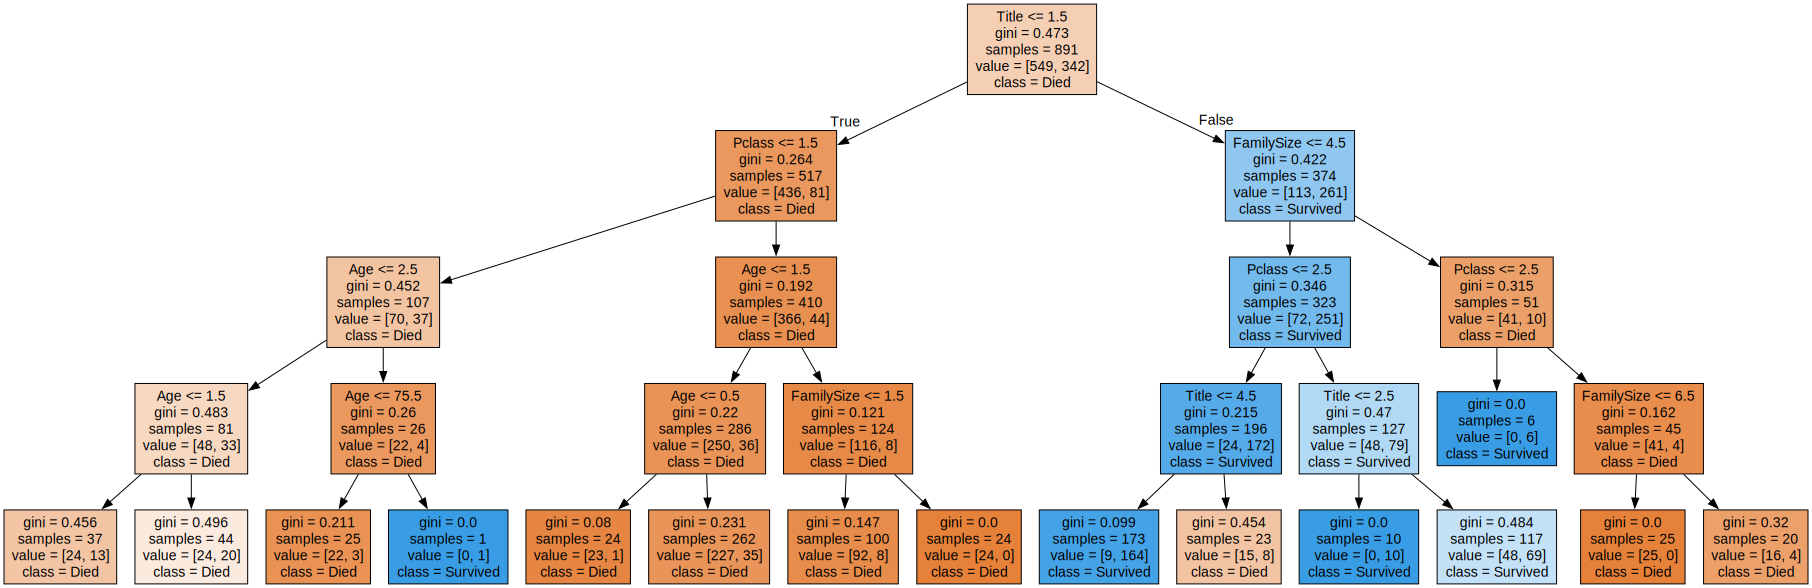

In [71]:
# 3. Plot the best classification tree

# Adjust regression tree with optimal depth
class_tree = DecisionTreeClassifier(max_depth=4)
class_tree.fit(X, y)
y_tree = class_tree.predict(X)

# Export the tree to "plot_tree.pdf"
plot_tree = export_graphviz(class_tree, out_file=None, feature_names=['Pclass', 'Sex', 'Age', 'FamilySize', 'Title'], class_names=["Died", "Survived"], filled=True) 
graph = Source(plot_tree) 
graph.render("class_tree")

# Plot the tree
graph

4. Explain the rules obtained to get the classification

The classifier of depth 4 uses 4 successive decisions to classify a data sample.

The root node used is the title, and the treshold for this node is separating Mr from other titles. This means, if the person has Mr as a title it's more probable that he would have died (There are 517 people with Mr title and 436 of them have died ).

When the title of a person is Mr, the level of confidence in the decision of predicting him dying is quite high except for some cases where the gini impurity is high. For example, when a person with Mr as a title has is in first class and has an age inferior than 48 the gini impurity is around 0,47 which reveals a small level of confidence in the prediction of him dying. In contrast, when the person with title Mr is in a P-class superior than 1, and has an age superior than 38 and a family size superior than 2, the confidence of predicting him dying is very high (a gini of 0 using 24 samples).

When the title of a person is different than Mr, there is more chance of him surviving especially if his family size is less than 4. The confidence in the predictions in this case is high when the Pclass is less than 2, and the title is Mrs or Master : the gini is equal to 0.99 using 173 samples.
With still a title different than Mr and if the family size is bigger than 4 and the class the person is in is superior than 3, then there is more chance of him dying. The confidence in this case is quite high (gini = 0.162 using 45 samples).

In conclusion, we can see that young men are more likely to die compared to others especially if they aren't in first class and have a big family size. We can explain that by the fact that women, children, elderly and men with high social status were more protected during the titanic tragedy and their survival was more prioritized.





    

## III - Multiple trees for binary classification

We consider another binary classification problem. The goal is to visualize the results of decision trees in nonlinear problems.

> 1. Generate data (x1, x2, y)
> 2. Apply classification trees with depth=1,2,3,4
> 3. Implement and compare the classification forest with depth=3 and the ada boost classifier

Text(0.5, 1.0, 'Binary classification')

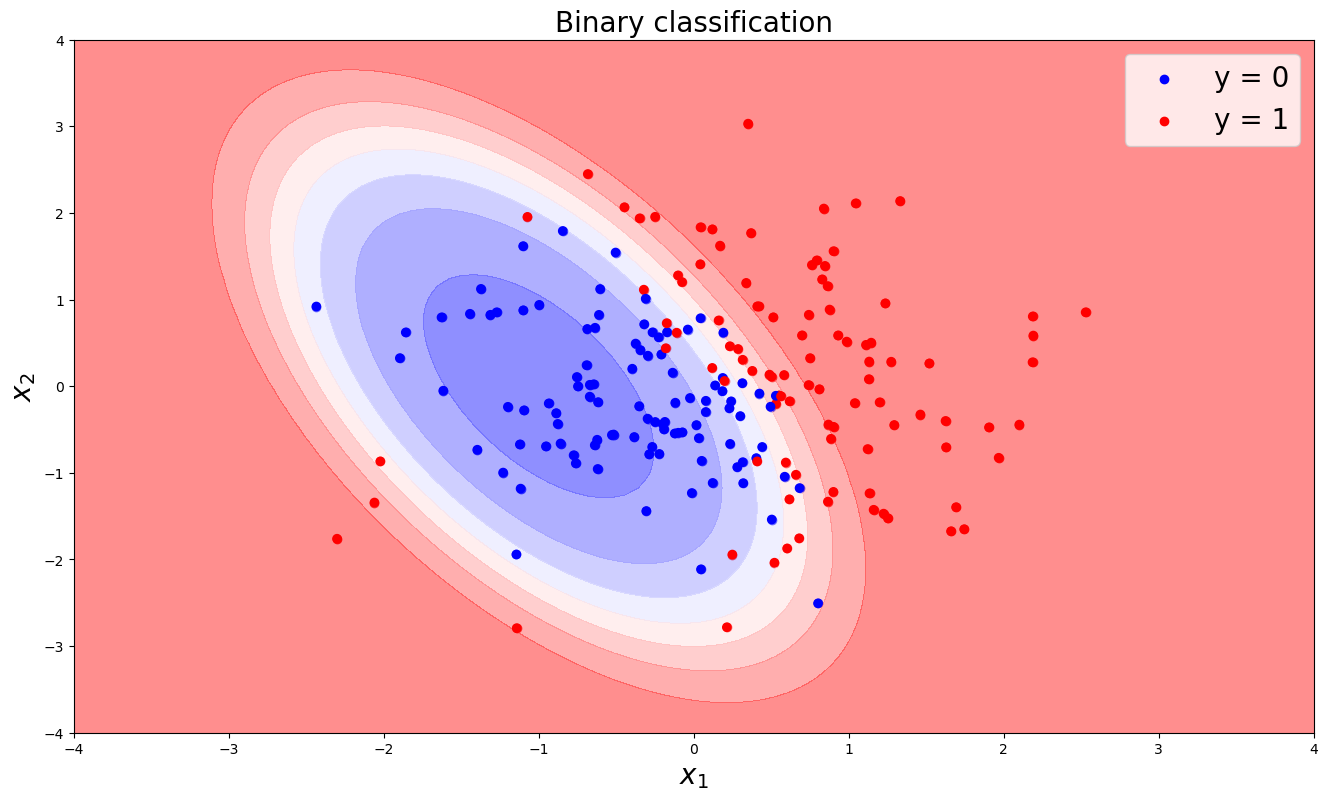

In [72]:
# 1. Generate the data

# Input variables
random.seed(1) # setting seed for reproducability
n = 200 # number of samples
x1 = randn(n, 1)
x2 = randn(n, 1)
x = hstack((x1, x2))

# True parameters
w0 = -0.5
w1 = 1.5
w2 = 0.5
w11 = 0.75
w22 = 0.25
w12 = 0.5

# Noise
epsilon = randn(n, 1)/3

# Output variable
y_noise = tanh(w0 + w1*x1 + w2*x2 + w11*x1**2 + w22*x2**2 + w12*x1*x2 + epsilon)
y = (y_noise>0) # transform to binary data

# For visualization
X1, X2 = meshgrid(linspace(-4, 4, 100), linspace(-4, 4, 100))
X = vstack((ravel(X1), ravel(X2))).T
Y = tanh(w0 + w1*X1 + w2*X2 + w11*X1**2 + w22*X2**2 + w12*X1*X2)

# Plot data
scatter(x1[y==0], x2[y==0], c='b')
scatter(x1[y==1], x2[y==1], c='r')
contourf(X1, X2, Y, cmap='bwr', alpha=0.5)
scatter(x1, x2, c=y, cmap='bwr')
legend(['y = 0', 'y = 1'], prop={'size': 20})
xlabel("$x_1$", fontsize=20)
ylabel("$x_2$", fontsize=20)
title('Binary classification', size=20)

Tree Classifier with depth 1 Accuracy: 0.82
Tree Classifier with depth 1  Report:
              precision    recall  f1-score   support

       False       0.78      0.91      0.84       102
        True       0.89      0.72      0.80        98

    accuracy                           0.82       200
   macro avg       0.83      0.82      0.82       200
weighted avg       0.83      0.82      0.82       200

Tree Classifier with depth 2 Accuracy: 0.86
Tree Classifier with depth 2  Report:
              precision    recall  f1-score   support

       False       0.85      0.88      0.87       102
        True       0.87      0.84      0.85        98

    accuracy                           0.86       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.86      0.86      0.86       200

Tree Classifier with depth 3 Accuracy: 0.89
Tree Classifier with depth 3  Report:
              precision    recall  f1-score   support

       False       0.84      0.96      0.90  

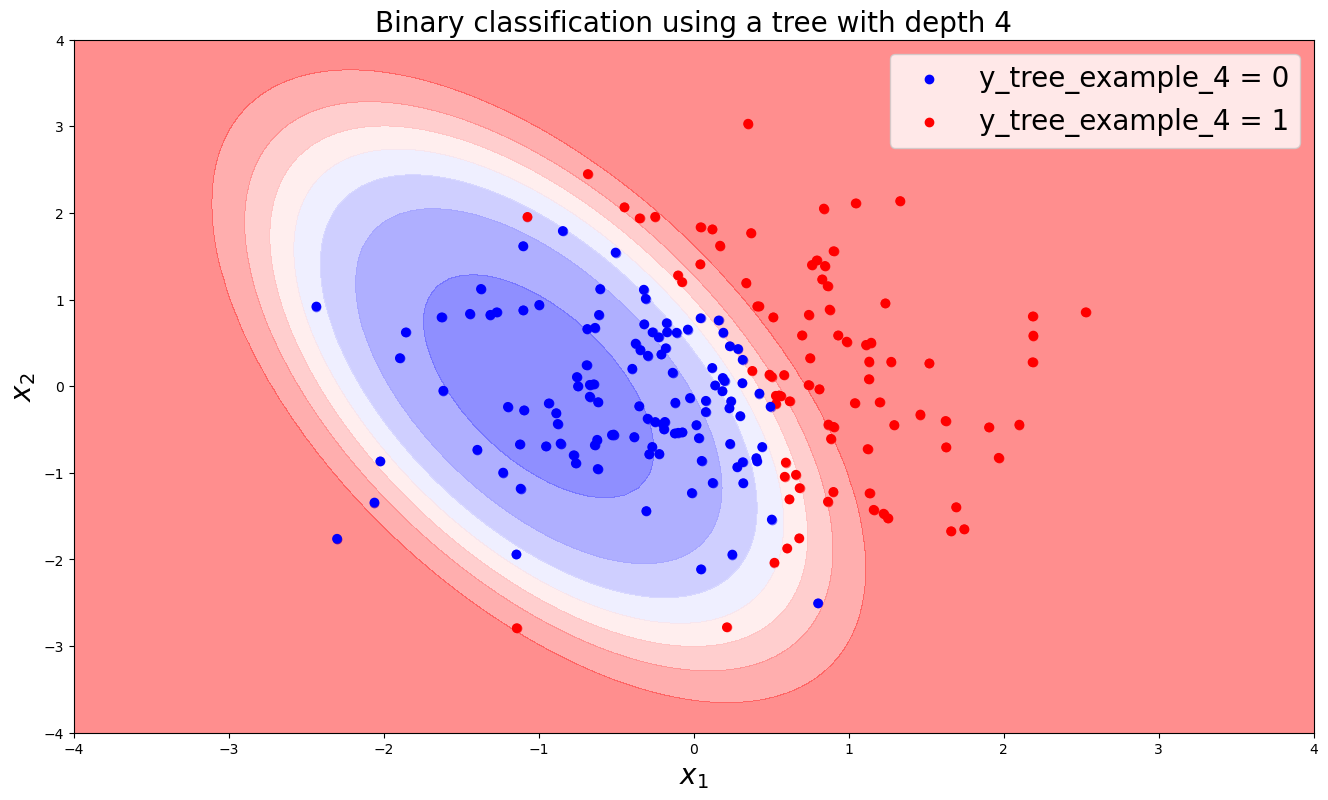

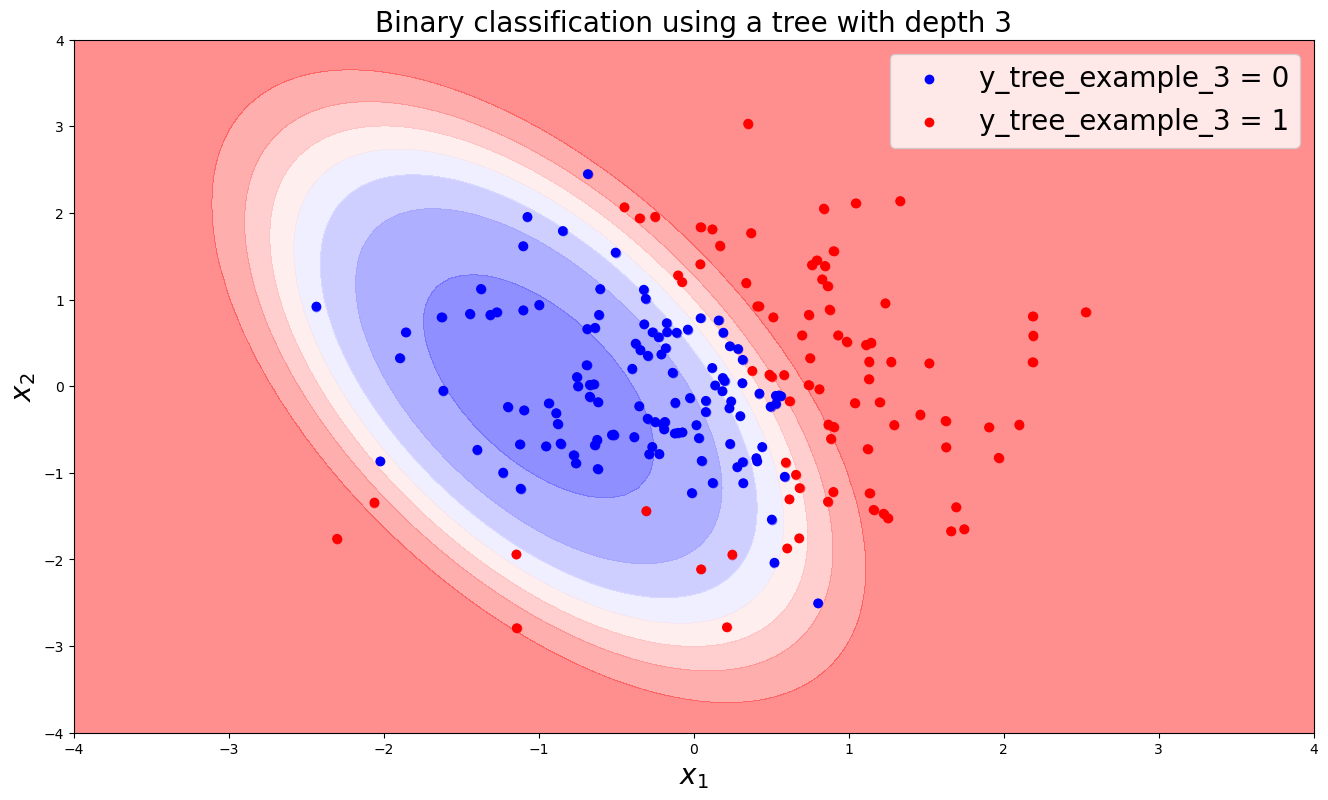

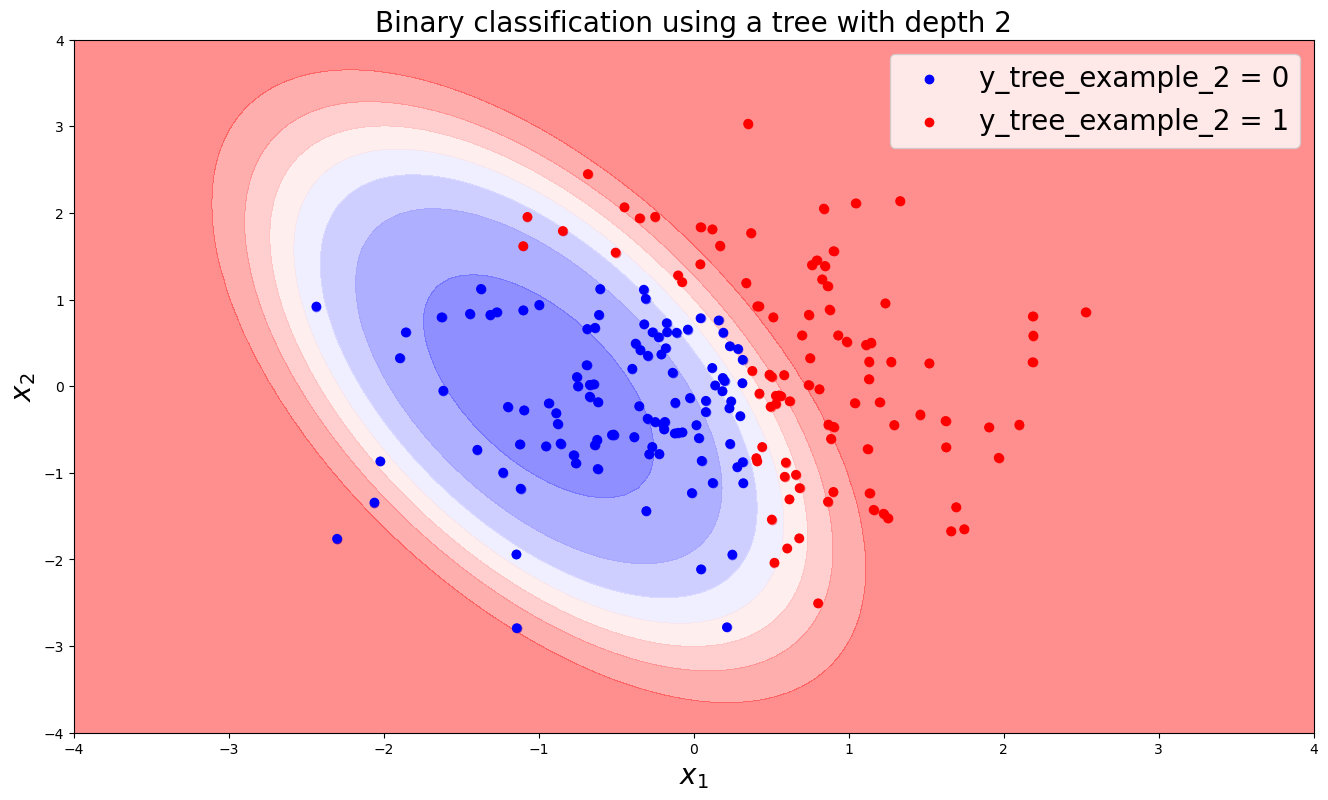

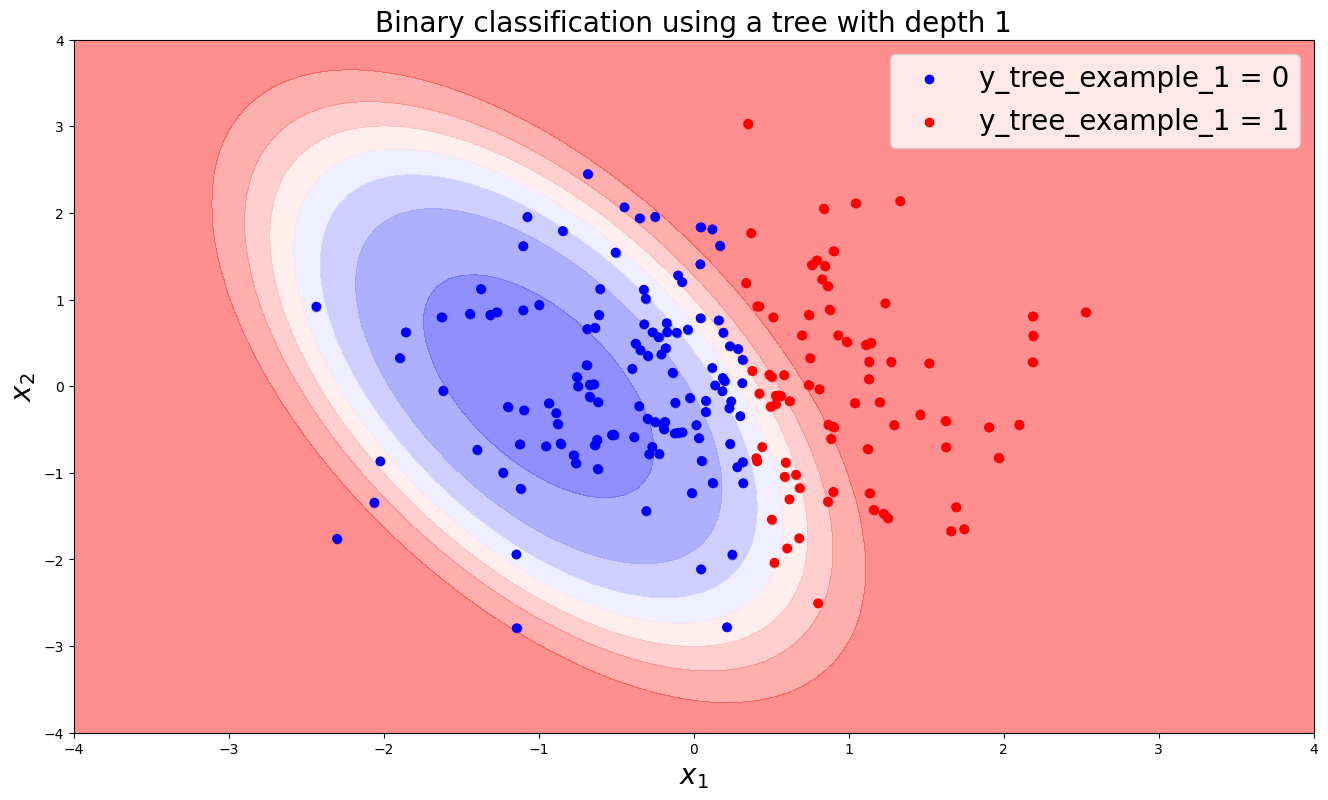

In [73]:
# 2. Apply classification trees with depth=1,2,3,4

# Build the tree (with depth=1)
class_tree_example_1 = DecisionTreeClassifier(max_depth=1)
class_tree_example_1.fit(x, y)
y_tree_example_1 = class_tree_example_1.predict(x)

# Build the trees (with depth=2)
class_tree_example_2 = DecisionTreeClassifier(max_depth=2)
class_tree_example_2.fit(x, y)
y_tree_example_2 = class_tree_example_2.predict(x)

# Build the trees (with depth=3)
class_tree_example_3 = DecisionTreeClassifier(max_depth=3)
class_tree_example_3.fit(x, y)
y_tree_example_3 = class_tree_example_3.predict(x)

# Build the trees (with depth=4)
class_tree_example_4 = DecisionTreeClassifier(max_depth=4)
class_tree_example_4.fit(x, y)
y_tree_example_4 = class_tree_example_4.predict(x)

# Plot data
figure()
scatter(x1[y_tree_example_4==0], x2[y_tree_example_4==0], c='b')
scatter(x1[y_tree_example_4==1], x2[y_tree_example_4==1], c='r')
contourf(X1, X2, Y, cmap='bwr', alpha=0.5)
scatter(x1, x2, c=y_tree_example_4, cmap='bwr')
legend(['y_tree_example_4 = 0', 'y_tree_example_4 = 1'], prop={'size': 20})
xlabel("$x_1$", fontsize=20)
ylabel("$x_2$", fontsize=20)
title('Binary classification using a tree with depth 4', size=20)

figure()
scatter(x1[y_tree_example_3==0], x2[y_tree_example_3==0], c='b')
scatter(x1[y_tree_example_3==1], x2[y_tree_example_3==1], c='r')
contourf(X1, X2, Y, cmap='bwr', alpha=0.5)
scatter(x1, x2, c=y_tree_example_3, cmap='bwr')
legend(['y_tree_example_3 = 0', 'y_tree_example_3 = 1'], prop={'size': 20})
xlabel("$x_1$", fontsize=20)
ylabel("$x_2$", fontsize=20)
title('Binary classification using a tree with depth 3', size=20)

figure()
scatter(x1[y_tree_example_2==0], x2[y_tree_example_2==0], c='b')
scatter(x1[y_tree_example_2==1], x2[y_tree_example_2==1], c='r')
contourf(X1, X2, Y, cmap='bwr', alpha=0.5)
scatter(x1, x2, c=y_tree_example_2, cmap='bwr')
legend(['y_tree_example_2 = 0', 'y_tree_example_2 = 1'], prop={'size': 20})
xlabel("$x_1$", fontsize=20)
ylabel("$x_2$", fontsize=20)
title('Binary classification using a tree with depth 2', size=20)


figure()
scatter(x1[y_tree_example_1==0], x2[y_tree_example_1==0], c='b')
scatter(x1[y_tree_example_1==1], x2[y_tree_example_1==1], c='r')
contourf(X1, X2, Y, cmap='bwr', alpha=0.5)
scatter(x1, x2, c=y_tree_example_1, cmap='bwr')
legend(['y_tree_example_1 = 0', 'y_tree_example_1 = 1'], prop={'size': 20})
xlabel("$x_1$", fontsize=20)
ylabel("$x_2$", fontsize=20)
title('Binary classification using a tree with depth 1', size=20)

# Evaluate Random Forest Classifier
y_trees = [y_tree_example_1, y_tree_example_2, y_tree_example_3, y_tree_example_4]
for i in range(4):
    tree_accuracy = accuracy_score(y, y_trees[i])
    print(f"Tree Classifier with depth {i + 1} Accuracy:", tree_accuracy)
    print(f"Tree Classifier with depth {i + 1}  Report:")
    print(classification_report(y, y_trees[i]))


In [74]:
# 3. Implement and compare the classification forest with depth=3 and the ada boost classifier

# Create a Random Forest Classifier with depth=3
forest_classifier = RandomForestClassifier(max_depth=3, random_state=1)
forest_classifier.fit(x, y)

# Predictions
y_forest = forest_classifier.predict(x)

# Create an AdaBoost Classifier
adaboost_classifier = AdaBoostClassifier(n_estimators=50, random_state=1)
adaboost_classifier.fit(x, y)

# Predictions
y_adaboost = adaboost_classifier.predict(x)

In [75]:
from sklearn.metrics import accuracy_score, classification_report

# Evaluate Random Forest Classifier
forest_accuracy = accuracy_score(y, y_forest)
print("Random Forest Classifier Accuracy:", forest_accuracy)
print("Random Forest Classifier Report:")
print(classification_report(y, y_forest))

# Evaluate AdaBoost Classifier
adaboost_accuracy = accuracy_score(y, y_adaboost)
print("\nAdaBoost Classifier Accuracy:", adaboost_accuracy)
print("AdaBoost Classifier Report:")
print(classification_report(y, y_adaboost))

Random Forest Classifier Accuracy: 0.9
Random Forest Classifier Report:
              precision    recall  f1-score   support

       False       0.87      0.95      0.91       102
        True       0.94      0.85      0.89        98

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200


AdaBoost Classifier Accuracy: 1.0
AdaBoost Classifier Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       102
        True       1.00      1.00      1.00        98

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



We can see that the Ada boost has a higher performance than the Random Forest: the accuracy of the Ada boost which is 1 is higher than the accuracy of the random forest with depth 3 which is 0.9.